In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [3]:
# reading the data
news_data = pd.read_csv('train.csv')
news_data.shape

(20800, 5)

In [4]:
# check for missing values
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

## Exploratory Data Analysis

In [5]:
def retrieve_author_name(feature):
    if isinstance(feature, list):
        feature = [re.sub(r'\band\b', ',', row) for row in feature]
        return [str.lower(row.replace(" ", "")) for row in feature]
    else:
        if isinstance(feature, str):
            feature = re.sub(r'\band\b', ',', feature)
            return str.lower(feature.replace(" ", ""))
        else:
            return ''

In [6]:
fake_news = news_data.loc[news_data.label == 0]
fake_news.head(5)
fake_news['author'] = fake_news.loc[:, 'author'].apply(retrieve_author_name)

C:\Users\qwert\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
from collections import Counter
author_count = Counter(fake_news['author'])

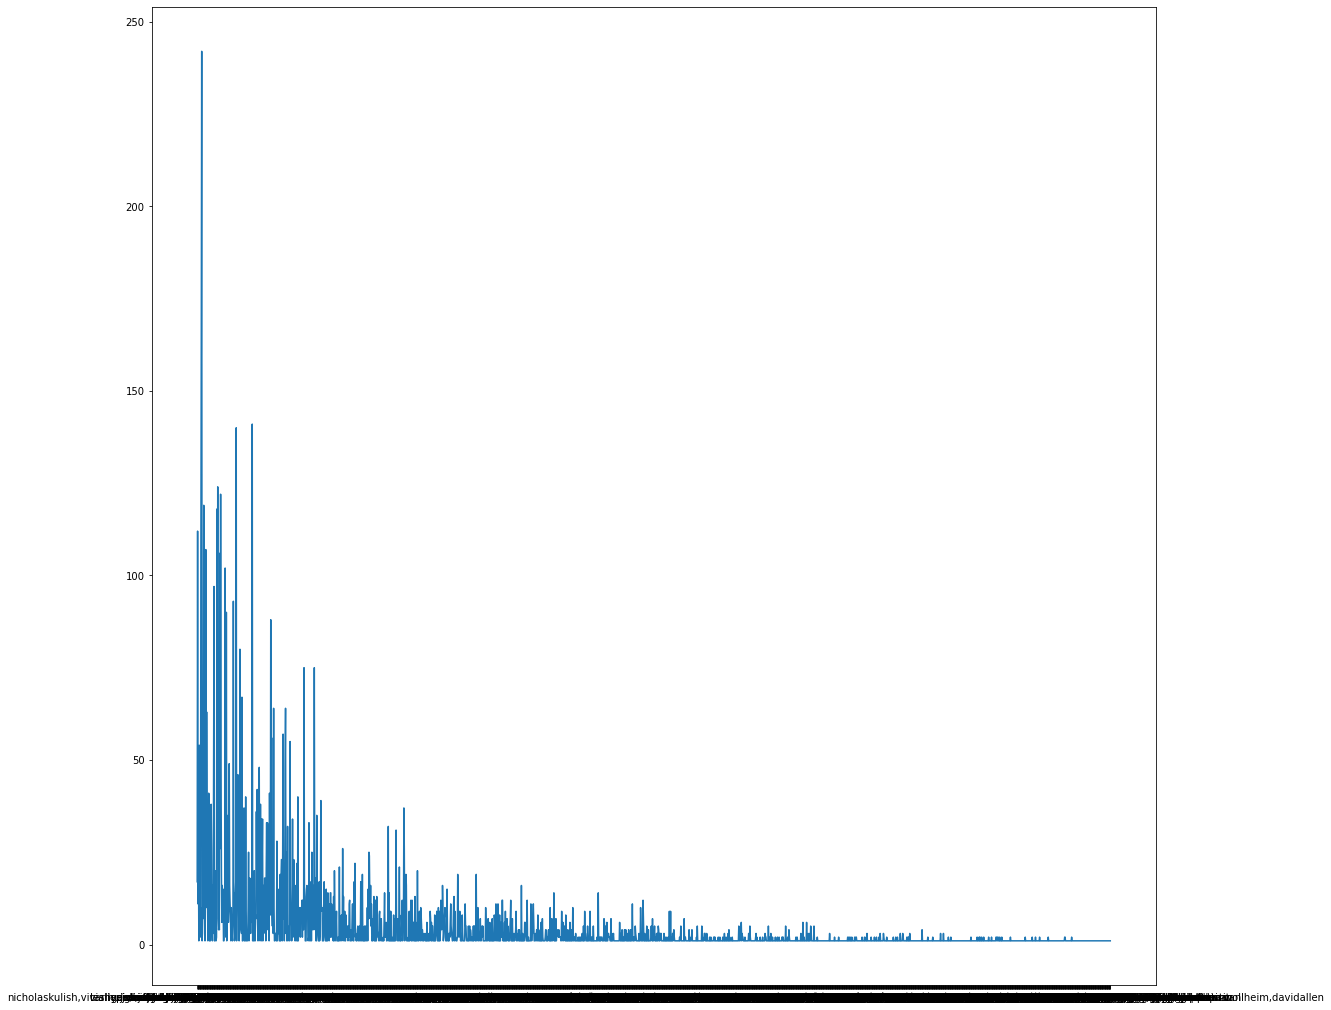

<Figure size 432x288 with 0 Axes>

In [8]:
# plot the author_count object 
plt.figure(figsize = (18, 18))
plt.plot(author_count.keys(), author_count.values())
plt.show()
plt.savefig('barplot.png')

## Feature Engineering and Selection

In [9]:
def feature_engineering(dataset):
    news_data = dataset.fillna('') 
    # Merge title and author attributes
    news_data['content'] = news_data['author'] + ' ' + news_data['title']
    return news_data

news_data = feature_engineering(news_data)
news_data.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [10]:
# stopwords removal and stemming
porter_stemmer = PorterStemmer()

def stem_content(content):
    preview = re.sub('[^a-zA-Z]', ' ', content)
    preview = preview.lower()
    preview = preview.split()
    preview = [porter_stemmer.stem(word) for word in preview \
               if not word in stopwords.words('english')]
    preview = ' '.join(preview)
    return preview

In [ ]:
news_data['content'] = news_data['content'].apply(stem_content)

In [ ]:
news_data['content'].head(5)

In [ ]:
X = news_data['content'].values
y = news_data['label'].values

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)
X.shape

In [ ]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,random_state = 0)

In [ ]:
# function to plot the confusion matrix
def plot_error_matrix(cm, classes, 
                     normalize = False, 
                     title = 'Error (Confusion) Matrix',
                     cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation= 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion matrix")
    else:
        print("Confusion matrix without normalization")
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > threshold else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')  

In [ ]:
# function to plot the ROC and AUC
def plot_roc_auc(target, predictions):
    auc = roc_auc_score(target, predictions)
    fpr, tpr, thresholds = roc_curve(target, predictions)
    plt.figure(figsize = (10, 5), dpi = 100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC and ROC Curve")
    plt.plot(fpr, tpr, 'g')
    plt.fill_between(fpr, tpr, facecolor = 'lightgreen', alpha = 0.7)
    plt.text(0.95, 0.1, f'AUC = {auc:.4%}', ha = 'right', fontsize = 12, weight = 'bold', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.show()

In [ ]:
def classify(clf, X = X_train, y = y_train, X_test = X_test, y_test = y_test):
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f_one = f1_score(y_test, y_pred)
    print(f"Accuracy: {score:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1: {f_one:.4%}")
    cm = confusion_matrix(y_test, y_pred)
    print("\n**************************")
    plot_error_matrix(cm,classes = ['FAKE', 'REAL'], normalize = False)
    print("\n**************************")
    plot_roc_auc(y_test, y_pred)

In [ ]:
# multinomial naive bayes
classify(MultinomialNB())

In [ ]:
# logistic regression
classify(LogisticRegression())

In [ ]:
# Decision Tree Classifier
classify(DecisionTreeClassifier())

In [ ]:
# Passive Agressive Classifier
classify(PassiveAggressiveClassifier())

In [ ]:
# test data
test_data = pd.read_csv('test.csv')
test_data.shape

In [ ]:
# check for missing values
test_data.isnull().sum()

In [ ]:
test_data = feature_engineering(test_data)
test_data.head()

In [ ]:
test_data['content'] = test_data['content'].apply(stem_content)

In [ ]:
X_final = test_data['content'].values
X_final = tfidf.transform(X_final)

In [ ]:
# let's overload the classify method
def classify(clf, X = X_train, y = y_train, X_test = X_test):
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    output = pd.DataFrame({'id':test_data.id, 'label':y_pred})
    output.to_csv('submission.csv', index = False)
    return output

In [ ]:
# making predictions
# we'll use the passive aggressive classifier 
# because it has the highest accuracy
# we use full full model of the train data without train_test_split 
output = classify(PassiveAggressiveClassifier(), X = X, y = y, X_test = X_final)
print(output)